In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

from access_science_shared import standardizer

In [5]:
from narrative import nar181026_heat_confidence_genes
from narrative import nar181205_networks

In [6]:
save_images = True

In [7]:
outfolder = '200428_pipeline_comparison'

In [8]:
ref_genes = standardizer.reference_genes(10090, 'orp')

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [9]:
pr = properties.genbank_validated_rna(10090)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])

In [10]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 


all_de_orp = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['younger']==4) &   
    (all_de['de_unit']=='both') & 
    (all_de['padj'].notnull()) &
    (all_de['gene_ncbi'].isin(ref_genes))

]

In [11]:
from scipy.stats import spearmanr

In [12]:
from natsort import natsorted

In [13]:
conditions = natsorted(all_de['condition'].unique())

In [14]:
de_set = all_de_orp.copy()

In [15]:
ages = all_de_orp['older'].unique()

In [16]:
ages

array([18., 12.,  9., 24.])

In [17]:
from itertools import product

In [18]:
# def get_out(de_set):
    
out = pd.DataFrame(index=tissues_to_consider, columns=ages)


for tissue, age in product(tissues_to_consider, ages):

    d = de_set[
        (de_set['older']==age) &
        (de_set['tissue']==tissue)
    ]

    d = d[['gene_ncbi', 'o_over_y']].dropna()
    d = pd.merge(d, pr)

    r, p = spearmanr(d['log_length'], d['o_over_y'])
    d = d.set_index('gene_ncbi')

    out.loc[tissue, age] = r


In [19]:
tissues = [
    'Adrenal', 'BAT', 'Blood', 'Brain', 'Cerebellum', 
    'Esophagus', 'GutEP', 'Heart', 'Kidney', 'LI', 
    'Liver', 'Lung', 'MuscSat', 'SI', 'Skin', 
    'Stomach', 'WAT'
]

ages = ['09', '12', '18', '24']

from itertools import product

rogan_results = pd.DataFrame(index=tissues, columns=ages)



for tissue, age in product(tissues, ages):

    path_to_data = inout.get_internal_path(
        (
            'datasets/other/direct_communication_from_rgrant/'
            '191106_DESeq2_analysis/'
            '191113_DESeq_ouput_age_{}M_tissue_{}_pfu_F0_over_age_04M_tissue_{}_pfu_F0.csv'.format(
                age,
                tissue,
                tissue
            )
        )
    )
    
    df = pd.read_csv(path_to_data, usecols=[
        'entrezgene_id',
        'log2FoldChange',
        'padj'
    ]).rename(columns={'entrezgene_id': 'gene_ncbi'})

    df = pd.merge(df, pr).dropna(subset = ['log2FoldChange', 'padj'])

    rogan_results.loc[tissue, age] = spearmanr(df['log_length'], df['log2FoldChange'])[0]

In [20]:
original = out.stack().reset_index().rename(columns={'level_0': 'tissue', 'level_1': 'age', 0: 'imbalance'})

In [21]:
rogan_results.columns = [float(x) for x in rogan_results.columns]

In [22]:
rogan = rogan_results.stack().reset_index().rename(columns={'level_0': 'tissue', 'level_1': 'age', 0: 'imbalance'})

In [23]:
master = pd.merge(original, rogan, on=['tissue', 'age'], suffixes=('_orig', '_rogan'))

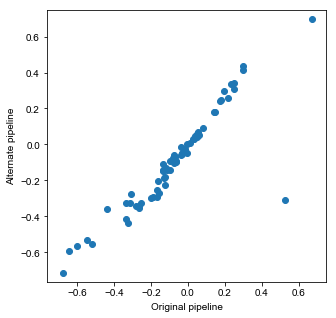

In [24]:

plt.figure(figsize=(5, 5))
plt.scatter(master['imbalance_orig'], master['imbalance_rogan'])
plt.xlabel('Original pipeline')
plt.ylabel('Alternate pipeline')

mi = master[['imbalance_orig', 'imbalance_rogan']].min(1).min()-0.05
ma = master[['imbalance_orig', 'imbalance_rogan']].max(1).max()+0.05
plt.xlim([mi, ma])
plt.ylim([mi, ma])



if save_images:
    export.export_image('{}/alternate_analysis_pipeline.pdf'.format(outfolder))



In [25]:
master[
    (master['imbalance_orig']>0) & 
    (master['imbalance_rogan']<0) 
]

,tissue,age,imbalance_orig,imbalance_rogan
24,Heart,18.0,0.526734,-0.306693


In [26]:
spearmanr(master['imbalance_orig'], master['imbalance_rogan'])

SpearmanrResult(correlation=0.9386952704508149, pvalue=3.106401990652173e-32)

In [27]:
if save_images:
    export.export_full_frame(
        os.path.join(outfolder, 'imbalances.xlsx'),
        master.sort_values('imbalance_orig')
    )